# Setup and load data

In [38]:
%load_ext autoreload
%autoreload 2

from functions.functions import *
from functions.plotting import *
from keras import backend as K
import tensorflow as tf
import numpy as np
import os
import glob
from itertools import combinations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
setup()

GPUs found: 1


In [34]:
data = load_data('data/mariel_*')

['data/mariel_betternot_and_retrograde.npy', 'data/mariel_beyond.npy', 'data/mariel_chunli.npy', 'data/mariel_honey.npy', 'data/mariel_knownbetter.npy', 'data/mariel_penelope.npy']


# Check out the real data

In [43]:
frame = 16000

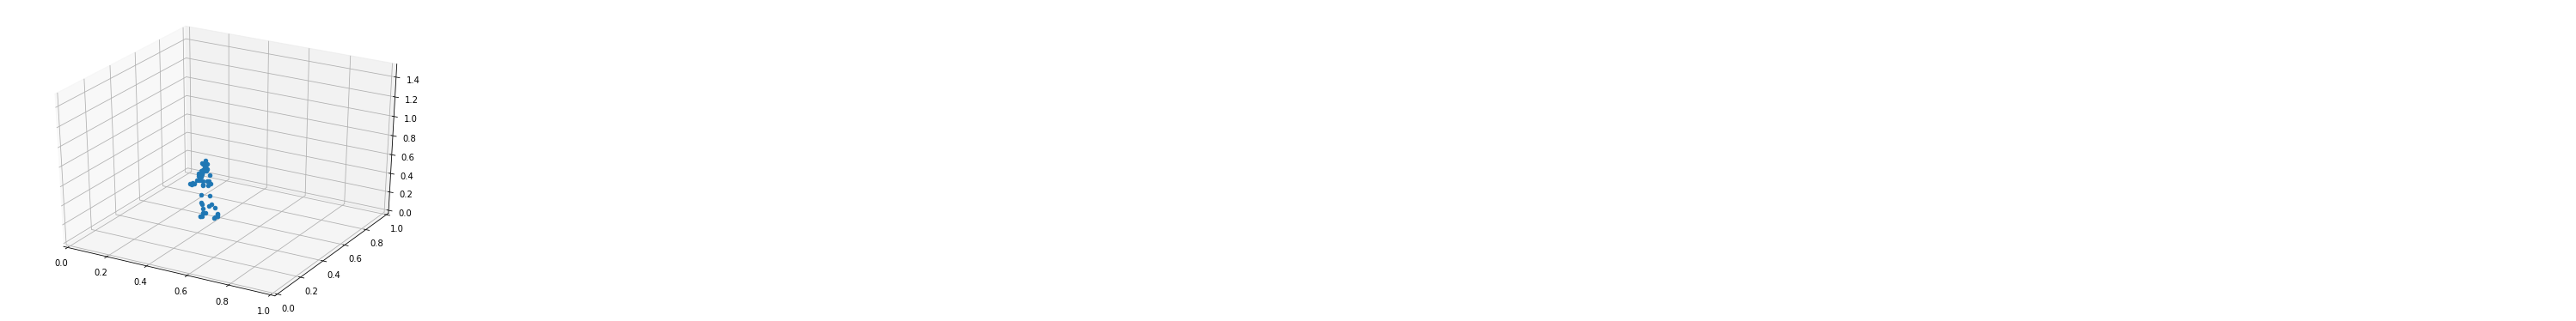

In [44]:
HTML(animate(data.full.X[:,frame:,:], frames=50))

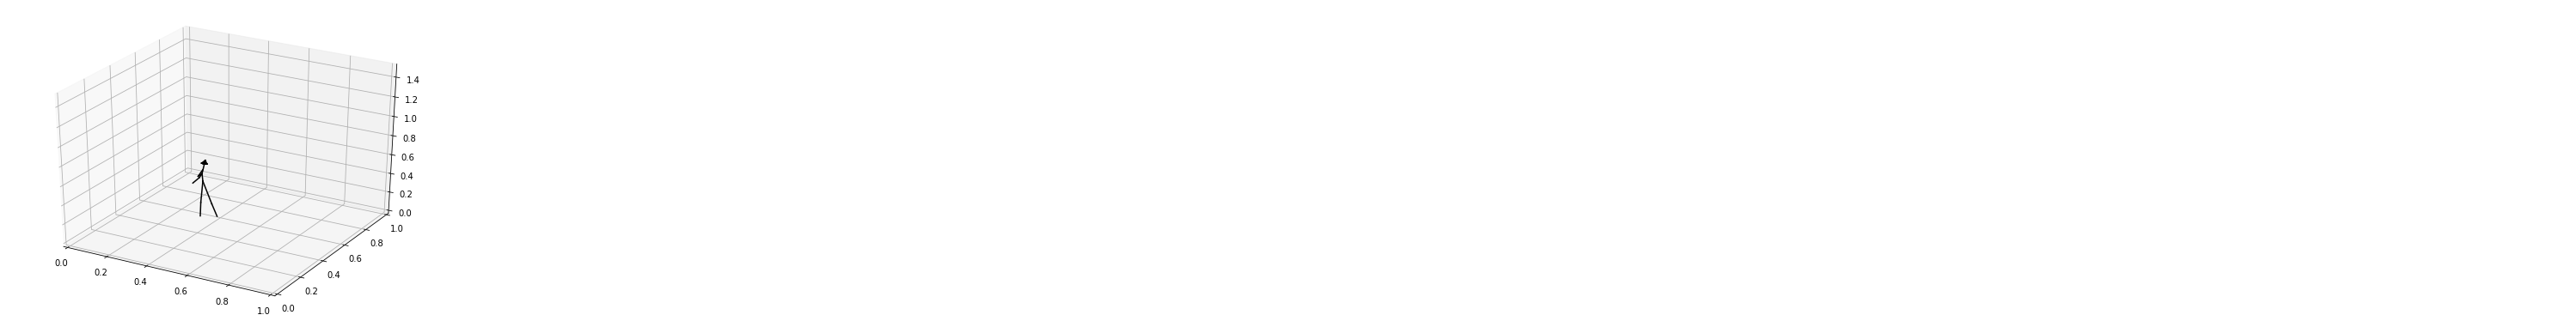

In [45]:
HTML(animate(data.selected.X[:,frame:,:], frames=50, edges=data.selected.edges, colors='black'))

In [10]:
# plot the body with labels for cherry picking edges
# plot_labelled_points(data.full.X, frame_idx=11000, text=True, figsize=(50,40), font_size=8)

In [14]:
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Flatten, Dropout, LeakyReLU, Add, Subtract, Lambda

class Autoencoder:
  def __init__(self,
               n_verts=0,
               n_dims=3,
               latent_dim=2,
               n_layers=2,
               n_units=128,
               relu=False,
               add_random_offsets=False,
               dropout=False):
    if not n_verts: raise Exception('Please provide the number of vertices `n_verts`')
    self.n_verts = n_verts # input vert count
    self.n_dims = n_dims # input dimensions
    self.relu = relu # whether to add relu layers in encoder/decoder
    self.dropout = dropout # whether to add dropout layers in encoder/decoder
    self.latent_dim = latent_dim
    self.n_layers = n_layers
    self.n_units = n_units
    self.encoder = self.build_encoder()
    self.decoder = self.build_decoder()
    # attach the encoder and decoder
    i = Input((self.n_verts, self.n_dims))
    if add_random_offsets:
        random_offsets = K.cast(K.learning_phase(),'float')*K.random_uniform((K.shape(i)[0],1,3))*K.constant([[[1,1,0]]])
        offset_layer = Lambda(lambda x: x + random_offsets)
        offset_layer.uses_learning_phase = True
        i_offset = offset_layer(i)
    else: 
        i_offset = i
    z = self.encoder(i_offset) # push observations into latent space
    o = self.decoder(z) # project from latent space to feature space
    if add_random_offsets:
        o = Lambda(lambda x: x - random_offsets)(o)
    self.model = Model(inputs=[i], outputs=[o])
    self.model.compile(loss='mse', optimizer='adam')
    
  def build_encoder(self):
    i = Input((self.n_verts, self.n_dims))
    h = i
    h = Flatten()(h)
    for _ in range(self.n_layers):
      h = Dense(self.n_units)(h)
      if self.relu: h = LeakyReLU(alpha=0.2)(h)
      if self.dropout: h = Dropout(0.4)(h)
    o = Dense(self.latent_dim)(h)
    return Model(inputs=[i], outputs=[o])
  
  def build_decoder(self):
    i = Input((self.latent_dim,))
    h = i
    for _ in range(self.n_layers):
      h = Dense(self.n_units)(h)
      if self.relu: h = LeakyReLU(alpha=0.2)(h)
      if self.dropout: h = Dropout(0.4)(h)
    h = Dense(self.n_verts * self.n_dims)(h)
    o = Reshape((self.n_verts, self.n_dims))(h) # predict 1 frame
    return Model(inputs=[i], outputs=[o])

  def train(self, X, n_epochs=10000):
    for idx in range(n_epochs):
      i = np.random.randint(0, X.shape[1]-1) # sample idx
      frame = np.expand_dims( X[:,i:i+1,:].squeeze(), axis=0) # shape = 1 sample, v verts, d dims
      loss = self.model.train_on_batch(frame, frame)
      if idx == 0: print(frame.shape)
      if idx % 1000 == 0:
        print(' * training idx', idx, 'loss', loss)

  def get_predictions(self, X, n_frames=50, start_frame=0):
    '''Return the model's predictions of observations from X in shape of X'''  
    predictions = []
    for i in range(start_frame, start_frame+n_frames, 1):
      x = np.expand_dims(X[:,i:i+1,:].squeeze(), axis=0)
      predictions.append( self.model.predict(x) )
    return np.swapaxes(np.vstack(predictions), 0, 1)

# Train the Autoencoder:

### Define the training dataset:

In [15]:
X_train = data.selected.X[:,:,:]    # 15 joints
# X_train = data.selected.X[:,:,:]    # 55 joints

### Train without adding random (x,y) offsets:

In [16]:
ae_nooffset = Autoencoder(n_verts=15, latent_dim=6, n_layers=2, n_units=128, relu=True, dropout=False, add_random_offsets=False)
X_T = X_train.transpose((1,0,2))
ae_nooffset.model.fit(X_T, X_T, batch_size = 128, epochs = 50)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
44309/44309 [==============================] - 1s 27us/step - loss: 0.0102
Epoch 2/50
44309/44309 [==============================] - 1s 21us/step - loss: 0.0011
Epoch 3/50
44309/44309 [==============================] - 1s 22us/step - loss: 8.1214e-04
Epoch 4/50
44309/44309 [==============================] - 1s 21us/step - loss: 7.2878e-04
Epoch 5/50
44309/44309 [==============================] - 1s 22us/step - loss: 6.7794e-04
Epoch 6/50
44309/44309 [==============================] - 1s 21us/step - loss: 6.4658e-04
Epoch 7/50
44309/44309 [==============================] - 1s 22us/step - loss: 6.2401e-04
Epoch 8/50
44309/44309 [==============================] - 1s 21us/step - loss: 6.0205e-04
Epoch 9/50
44309/44309 [==============================] - 1s 22us/step - loss: 5.8756e-04
Epoch 10/50
44309/44309 [==============================] - 1s 22us/step - loss

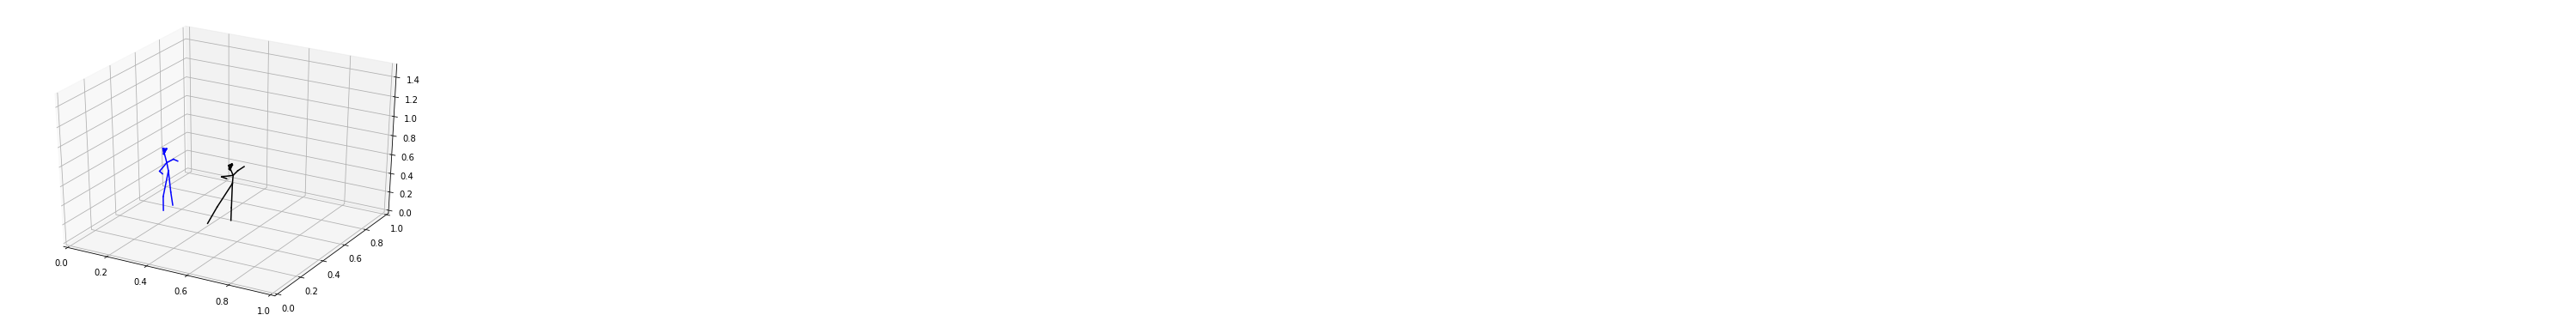

In [17]:
# autoencoded prediction in blue, real data in black:
starting_frame = 16600
n_frames = 100
predictions = ae_nooffset.get_predictions(X_train, start_frame=starting_frame, n_frames=n_frames)
HTML(animate_ghost(data.selected.X[:,starting_frame:,:], predictions, frames=n_frames, edges=data.selected.edges, colors='blue'))

### Train with adding random (x,y) offsets to the input data:

In [18]:
ae_withoffset = Autoencoder(n_verts=15, latent_dim=6, n_layers=2, n_units=128, relu=True, dropout=False, add_random_offsets=False)
X_T = X_train.transpose((1,0,2))
ae_withoffset.model.fit(X_T, X_T, batch_size = 128, epochs = 50)

Epoch 1/50
44309/44309 [==============================] - 1s 27us/step - loss: 0.0092
Epoch 2/50
44309/44309 [==============================] - 1s 22us/step - loss: 0.0011
Epoch 3/50
44309/44309 [==============================] - 1s 22us/step - loss: 8.2887e-04
Epoch 4/50
44309/44309 [==============================] - 1s 22us/step - loss: 7.5641e-04
Epoch 5/50
44309/44309 [==============================] - 1s 22us/step - loss: 6.9950e-04
Epoch 6/50
44309/44309 [==============================] - 1s 22us/step - loss: 6.5026e-04
Epoch 7/50
44309/44309 [==============================] - 1s 22us/step - loss: 5.9923e-04
Epoch 8/50
44309/44309 [==============================] - 1s 22us/step - loss: 5.4833e-04
Epoch 9/50
44309/44309 [==============================] - 1s 22us/step - loss: 5.2532e-04
Epoch 10/50
44309/44309 [==============================] - 1s 22us/step - loss: 5.0496e-04
Epoch 11/50
44309/44309 [==============================] - 1s 22us/step - loss: 4.9303e-04
Epoch 12/50
4430

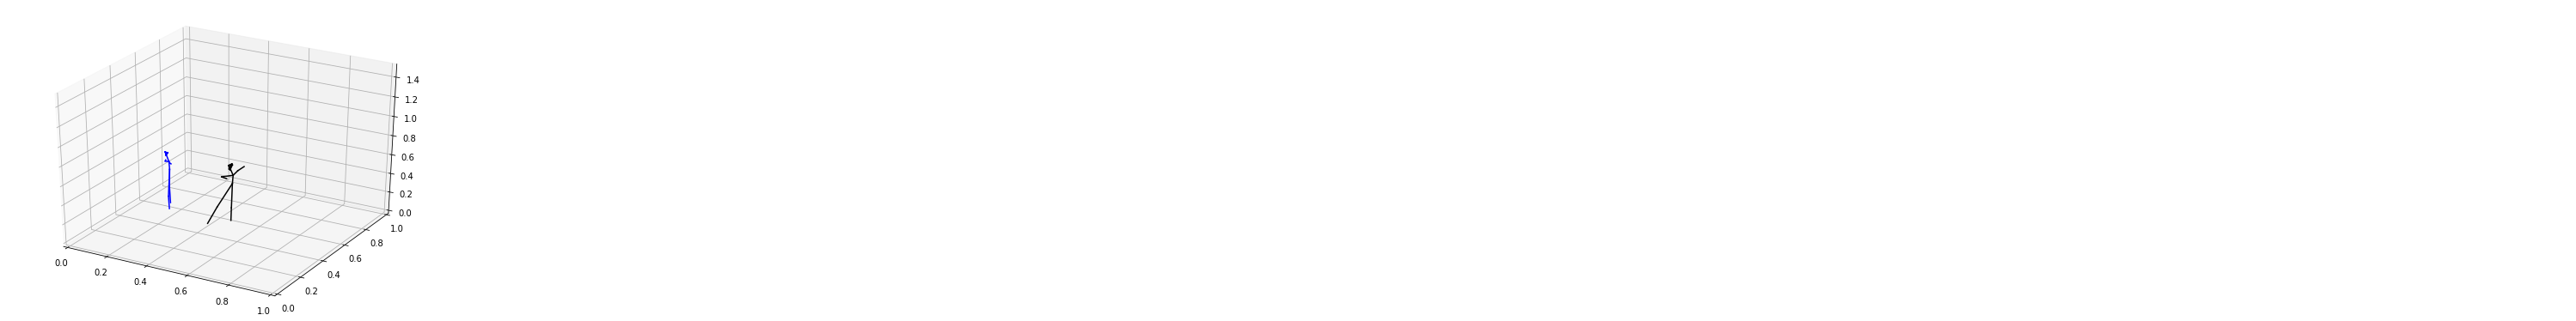

In [19]:
# autoencoded prediction in blue, real data in black:
starting_frame = 16600
n_frames = 100
predictions = ae_withoffset.get_predictions(X_train, start_frame=starting_frame, n_frames=n_frames)
HTML(animate_ghost(data.selected.X[:,starting_frame:,:], predictions, frames=n_frames, edges=data.selected.edges, colors='blue'))

In [20]:
# # Analyze the autoencoder latent space
# X = data.selected.X
# encoded = []
# for idx, i in enumerate(range(X.shape[1])):
#   positions = np.expand_dims(X[:,i,:].squeeze(), axis=0)
#   encoded.append( ae.encoder.predict(positions) )
#   if idx and idx % 10000 == 0:
#     print(' * processed', idx, 'of', X.shape[1])
# encoded = np.array(encoded).squeeze() # shape = (13463, ae.latent_dim)

# # draw the plot
# fig = plt.figure(figsize=(20, 14))
# ax = p3.Axes3D(fig)
# ax.scatter(encoded[:,0], encoded[:,1], encoded[:,2], depthshade=False, alpha=0.3, s=0.5, c=np.arange(len(encoded)))

# LSTM + MDN

In [21]:
# adapted from https://raw.githubusercontent.com/omimo/Keras-MDN/master/kmdn/mdn.py
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Dense, Input, merge, concatenate, Dense, LSTM, CuDNNLSTM
from keras.engine.topology import Layer
from keras import backend as K
import tensorflow_probability as tfp
import tensorflow as tf
from keras.models import load_model


# check tfp version, as tfp causes cryptic error if out of date
assert float(tfp.__version__.split('.')[1]) >= 5

class MDN(Layer):
  '''Mixture Density Network with unigaussian kernel'''
  def __init__(self, n_mixes, output_dim, **kwargs):
    self.n_mixes = n_mixes
    self.output_dim = output_dim

    with tf.name_scope('MDN'):
      self.mdn_mus    = Dense(self.n_mixes * self.output_dim, name='mdn_mus')
      self.mdn_sigmas = Dense(self.n_mixes, activation=K.exp, name='mdn_sigmas')
      self.mdn_alphas = Dense(self.n_mixes, activation=K.softmax, name='mdn_alphas')
    super(MDN, self).__init__(**kwargs)

  def build(self, input_shape):
    self.mdn_mus.build(input_shape)
    self.mdn_sigmas.build(input_shape)
    self.mdn_alphas.build(input_shape)
    self.trainable_weights = self.mdn_mus.trainable_weights + \
      self.mdn_sigmas.trainable_weights + \
      self.mdn_alphas.trainable_weights
    self.non_trainable_weights = self.mdn_mus.non_trainable_weights + \
      self.mdn_sigmas.non_trainable_weights + \
      self.mdn_alphas.non_trainable_weights
    self.built = True

  def call(self, x, mask=None):
    with tf.name_scope('MDN'):
      mdn_out = concatenate([
        self.mdn_mus(x),
        self.mdn_sigmas(x),
        self.mdn_alphas(x)
      ], name='mdn_outputs')
    return mdn_out

  def get_output_shape_for(self, input_shape):
    return (input_shape[0], self.output_dim)

  def get_config(self):
    config = {
      'output_dim': self.output_dim,
      'n_mixes': self.n_mixes,
    }
    base_config = super(MDN, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def get_loss_func(self):
    def unigaussian_loss(y_true, y_pred):
      mix = tf.range(start = 0, limit = self.n_mixes)
      out_mu, out_sigma, out_alphas = tf.split(y_pred, num_or_size_splits=[
        self.n_mixes * self.output_dim,
        self.n_mixes,
        self.n_mixes,
      ], axis=-1, name='mdn_coef_split')

      def loss_i(i):
        batch_size = tf.shape(out_sigma)[0]
        sigma_i = tf.slice(out_sigma, [0, i], [batch_size, 1], name='mdn_sigma_slice')
        alpha_i = tf.slice(out_alphas, [0, i], [batch_size, 1], name='mdn_alpha_slice')
        mu_i = tf.slice(out_mu, [0, i * self.output_dim], [batch_size, self.output_dim], name='mdn_mu_slice')
        dist = tfp.distributions.Normal(loc=mu_i, scale=sigma_i)
        loss = dist.prob(y_true) # find the pdf around each value in y_true
        loss = alpha_i * loss
        return loss

      result = tf.map_fn(lambda  m: loss_i(m), mix, dtype=tf.float32, name='mix_map_fn')
      result = tf.reduce_sum(result, axis=0, keepdims=False)
      result = -tf.log(result)
      result = tf.reduce_mean(result)
      return result

    with tf.name_scope('MDNLayer'):
      return unigaussian_loss

class LSTM_MDN:
  def __init__(self, n_verts=15, n_dims=3, n_mixes=2, look_back=1, cells=[32,32,32,32], use_mdn=True):
    self.n_verts = n_verts
    self.n_dims = n_dims
    self.n_mixes = n_mixes
    self.look_back = look_back
    self.cells = cells
    self.use_mdn = use_mdn
    self.LSTM = CuDNNLSTM if len(gpus) > 0 else LSTM
    self.model = self.build_model()
    if use_mdn:
      self.model.compile(loss=MDN(n_mixes, n_verts*n_dims).get_loss_func(), optimizer='adam', metrics=['accuracy'])
    else:
      self.model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    
  def build_model(self):
    i = Input((self.look_back, self.n_verts*self.n_dims))
    h = self.LSTM(self.cells[0], return_sequences=True)(i) # return sequences, stateful
    h = self.LSTM(self.cells[1], return_sequences=True)(h)
    h = self.LSTM(self.cells[2])(h)
    h = Dense(self.cells[3])(h)
    if self.use_mdn:
      o = MDN(self.n_mixes, self.n_verts*self.n_dims)(h)
    else:
      o = Dense(self.n_verts*self.n_dims)(h)
    return Model(inputs=[i], outputs=[o])
  
  def prepare_inputs(self, X, look_back=2):
    '''
    Prepare inputs in shape expected by LSTM
    @returns:
      numpy.ndarray train_X: has shape: n_samples, lookback, verts * dims
      numpy.ndarray train_Y: has shape: n_samples, verts * dims
    '''
    # prepare data for the LSTM_MDN
    X = X.swapaxes(0, 1) # reshape to time, vert, dim
    n_time, n_verts, n_dims = X.shape
    
    # validate shape attributes
    if n_verts != self.n_verts: raise Exception(' ! got', n_verts, 'vertices, expected', self.n_verts)
    if n_dims != self.n_dims: raise Exception(' ! got', n_dims, 'dims, expected', self.n_dims)
    if look_back != self.look_back: raise Exception(' ! got', look_back, 'for look_back, expected', self.look_back)
    
    # lstm expects data in shape [samples_in_batch, timestamps, values]
    train_X = []
    train_Y = []
    for i in range(look_back, n_time, 1):
      train_X.append( X[i-look_back:i,:,:].reshape(look_back, n_verts * n_dims) ) # look_back, verts * dims
      train_Y.append( X[i,:,:].reshape(n_verts * n_dims) ) # verts * dims
    train_X = np.array(train_X) # n_samples, lookback, verts * dims
    train_Y = np.array(train_Y) # n_samples, verts * dims
    return [train_X, train_Y]
  
  def predict_positions(self, input_X):
    '''
    Predict the output for a series of input frames. Each prediction has shape (1, y), where y contains:
      mus = y[:n_mixes*n_verts*n_dims]
      sigs = y[n_mixes*n_verts*n_dims:-n_mixes]
      alphas = softmax(y[-n_mixes:])
    @param numpy.ndarray input_X: has shape: n_samples, look_back, n_verts * n_dims
    @returns:
      numpy.ndarray X: has shape: verts, time, dims
    '''
    predictions = []
    for i in range(input_X.shape[0]):
      y = self.model.predict( train_X[i:i+1] ).squeeze()
      mus = y[:n_mixes*n_verts*n_dims]
      sigs = y[n_mixes*n_verts*n_dims:-n_mixes]
      alphas = self.softmax(y[-n_mixes:])

      # find the most likely distribution then pull out the mus that correspond to that selected index
      alpha_idx = np.argmax(alphas) # 0
      alpha_idx = 0
      predictions.append( mus[alpha_idx*self.n_verts*self.n_dims:(alpha_idx+1)*self.n_verts*self.n_dims] )
    predictions = np.array(predictions).reshape(train_X.shape[0], self.n_verts, self.n_dims).swapaxes(0, 1)
    return predictions # shape = n_verts, n_time, n_dims
    
  def softmax(self, x):
    ''''Compute softmax values for vector `x`'''
    r = np.exp(x - np.max(x))
    return r / r.sum()

In [22]:
X = data.selected.X
n_verts, n_time, n_dims = X.shape
n_mixes = 3
look_back = 10

lstm_mdn = LSTM_MDN(n_verts=n_verts, n_dims=n_dims, n_mixes=n_mixes, look_back=look_back)
train_X, train_Y = lstm_mdn.prepare_inputs(X, look_back=look_back)

lstm_mdn = LSTM_MDN(n_verts=n_verts, n_dims=n_dims, n_mixes=n_mixes, look_back=look_back)
lstm_mdn.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10, 45)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 32)            9984      
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 32)            8320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
mdn_3 (MDN)                  (None, 32)                4653      
Total params: 32,333
Trainable params: 32,333
Non-trainable params: 0
_________________________________________________________________


In [23]:
from keras.callbacks import TerminateOnNaN, ModelCheckpoint
checkpoint_filepath="lstm_nopca_weights.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

In [24]:
# Train the model:
lstm_mdn.model.fit(train_X, train_Y, epochs=10, batch_size=64, shuffle=False, callbacks=[checkpoint, TerminateOnNaN()])

Epoch 1/10
44299/44299 [==============================] - 12s 264us/step - loss: -0.4843 - acc: 0.1026

Epoch 00001: acc improved from -inf to 0.10264, saving model to lstm_nopca_weights.h5
Epoch 2/10
44299/44299 [==============================] - 10s 230us/step - loss: -0.6243 - acc: 0.1142

Epoch 00002: acc improved from 0.10264 to 0.11418, saving model to lstm_nopca_weights.h5
Epoch 3/10
44299/44299 [==============================] - 10s 230us/step - loss: -0.7389 - acc: 0.0609

Epoch 00003: acc did not improve from 0.11418
Epoch 4/10
44299/44299 [==============================] - 10s 229us/step - loss: -0.9152 - acc: 0.1017

Epoch 00004: acc did not improve from 0.11418
Epoch 5/10
44299/44299 [==============================] - 10s 229us/step - loss: -1.1658 - acc: 0.1515

Epoch 00005: acc improved from 0.11418 to 0.15154, saving model to lstm_nopca_weights.h5
Epoch 6/10
44299/44299 [==============================] - 10s 230us/step - loss: -1.3210 - acc: 0.1699

Epoch 00006: acc imp

In [25]:
trained_model = lstm_mdn
# trained_model.model.load_weights('lstm_nopca_weights-best.h5')

### See how well the model can predict the next frame in the input sequence:

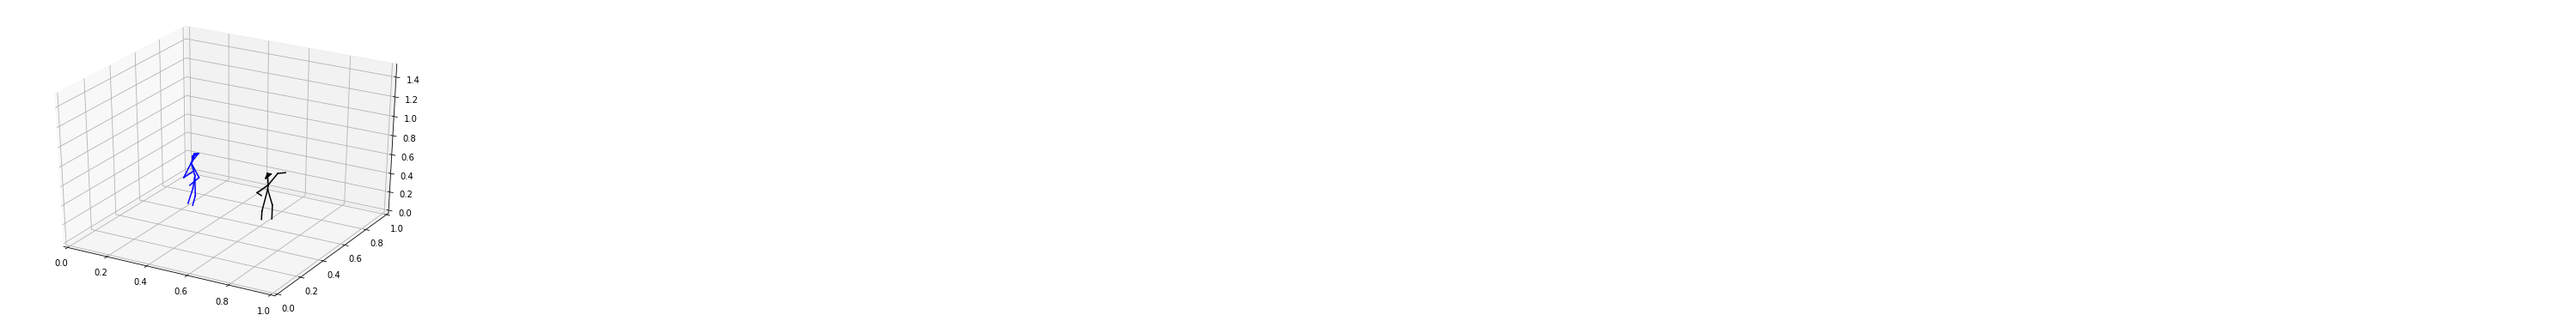

In [26]:
# visualize how well the model learned the input sequence
starting_frame = 1400
n_frames = 100 # n frames of time slices to generate
output_dims = train_X.shape[2]

frames = []

test_X = train_X[starting_frame:starting_frame+n_frames] # data to pass into forward prop through the model
y_pred = trained_model.model.predict(test_X) # output with shape (n_frames, (output_dims+2) * n_mixes )

# partition out the mus, sigs, and mixture weights
for i in range(n_frames):
    y = y_pred[i].squeeze()
    mus = y[:n_mixes*output_dims]
    sigs = y[n_mixes*output_dims:n_mixes*output_dims + n_mixes]
    alphas = y[-n_mixes:]

    # find the most likely distribution - then disregard that number and use the first Gaussian :)
    alpha_idx = np.argmax(alphas)
    alpha_idx = 0

    # pull out the mus that correspond to the selected alpha index
    positions = mus[alpha_idx * output_dims:(alpha_idx+1) * output_dims]
    frames.append(positions)
  
frames = np.array(frames)
lstm_predictions = np.dstack((frames.T[::3,:],frames.T[1::3,:],frames.T[2::3,:]))
HTML(animate_ghost(data.selected.X[:,starting_frame:,:], lstm_predictions[:,:,:], frames=n_frames, edges=data.selected.edges, colors='blue', ghost_shift = 0.3))

# Now generate new sequences!

In [29]:
trained_model.model.predict(x).shape

(44299, 141)

In [30]:
n_frames = 100 # n frames of time slices to generate
frames = []

seed = np.random.randint(0, len(train_X)-1)
x = np.expand_dims(train_X[seed], axis=0)
print(' * seeding with', seed)

for i in range(n_frames):
    y = trained_model.model.predict(x).squeeze()
    mus = y[:n_mixes*output_dims]
    sigs = y[n_mixes*output_dims:-n_mixes]
    alphas = softmax(y[-n_mixes:])

    # select the alpha channel to use
    alpha_idx = np.argmax(alphas)

    # grab the mus and sigs associated with the selected alpha_idx
    frame_mus = mus.ravel()[alpha_idx*output_dims : (alpha_idx+1)*output_dims]
    frame_sig = sigs[alpha_idx] / 100

    # now sample from each Gaussian
    positions = [np.random.normal(loc=m, scale=frame_sig) for m in frame_mus]
    positions = frame_mus

    # add these positions to the results
    frames.append(positions)

    # pull out a new training example - stack the new result on
    # all values after the first from the bottom-most value in the x's
    start = x[:,1:,:]
    end = np.expand_dims( np.expand_dims(positions, axis=0), axis=0 )
    x = np.concatenate((start, end), axis=1)
    
frames = np.array(frames)
lstm_predictions = np.dstack((frames.T[::3,:],frames.T[1::3,:],frames.T[2::3,:]))

prompt_plus_generated_seq = np.concatenate((data.selected.X[:,seed:seed+10,:],lstm_predictions), axis=1)

HTML(animate(prompt_plus_generated_seq, frames=n_frames, edges=data.selected.edges, colors='black'))

 * seeding with 26759


NameError: name 'softmax' is not defined

NEXT STEPS:
- (x,y centering)
- augment with random rotations